<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [1]:
# !pip install -q gdown torch transformers==4.49 transformers accelerate bitsandbytes langchain sentence-transformers langchain-chroma openpyxl datasets langchain-community ragatouille umap-learn

In [2]:
# !pip install --upgrade --force-reinstall numpy datasets --no-cache-dir

In [3]:
# !pip install numpy==2.0

In [ ]:
import base64
import random
from io import BytesIO
from typing import List, Tuple

import datasets
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import umap
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from PIL import Image
from ragatouille import RAGPretrainedModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)

torch.cuda.empty_cache()

## Загрузка данных (4 балла)

In [5]:
url = "https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk"
output = "file.csv"

gdown.download(url, output, quiet=False)

data = pd.read_csv("file.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=9db2b4cb-1ed3-483c-8474-7e0eca618a69
To: /content/file.csv
100%|██████████| 672M/672M [00:08<00:00, 76.6MB/s]


In [6]:
data.head(5)

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


In [7]:
data.tail(5)

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
14629,4367,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a statue of a man on a staircase in a...
14630,4368,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a large red brick building with many ...
14631,4369,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are statues on the wall of a building wi...
14632,4370,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,cars are parked in front of a large brick buil...
14633,4371,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a large red building with a lot of wi...


In [8]:
data.shape

(14634, 9)

Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [10]:
def get_image(data):
    image = Image.open(BytesIO(base64.b64decode(data))).convert("RGB")
    return image

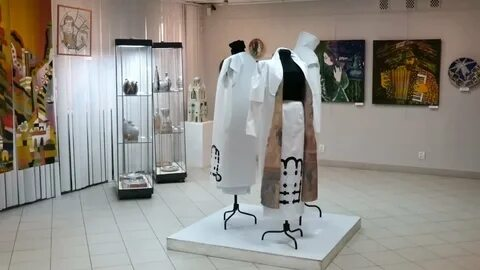

In [11]:
get_image(data.sample(1)["image"].tolist()[0])

Динамо - there are two people that are standing on a track in a stadium


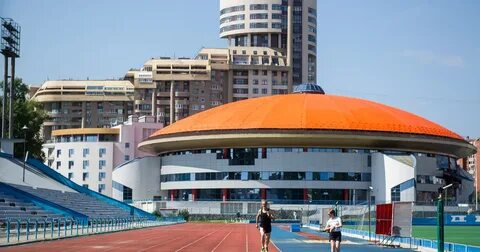

In [12]:
print(data.iloc[0]["Name"], "-", data.iloc[0]["en_txt"])
get_image(data.iloc[0]["image"])

Динамо - arafed building with a blue and white exterior and a blue fence


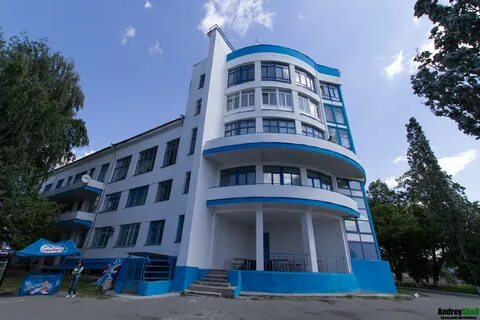

In [13]:
print(data.iloc[1]["Name"], "-", data.iloc[1]["en_txt"])
get_image(data.iloc[1]["image"])

Динамо - there is a blue and white building with a clock on top


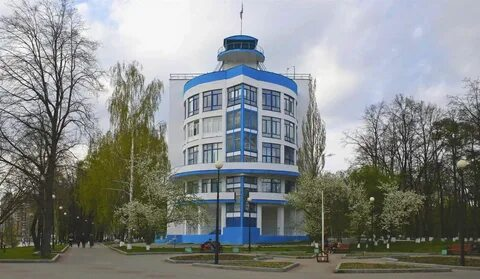

In [14]:
print(data.iloc[2]["Name"], "-", data.iloc[2]["en_txt"])
get_image(data.iloc[2]["image"])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

# Решение задания:
Отфильтровать нерелевантные описания по tf-idf у меня не получилось даже с испопльзованием препроцессинга (возможно, из-за того, что описания очень короткие). Поэтому решил отсортировать все описания "по похожести", те описания, которые меньше всего похожи на остальные, скорее всего не будут относиться к достопримечательностям, тк достопримечательностей больше всего. Порог схожести для удаления нерелевантных описания выбирал вручную, смотря на изображения и описания в отсортированном списке. Процесс повторял несколько раз, пока не перестал находить явно неподходящие классы в начале списка. Неподходящие классы удалял вручную.

В итоге осталось около 9к записей, из них решил оставить все, у которых значение похожести больше 0.2 (примерно 7к)

In [15]:
data = data.drop_duplicates(subset="image", keep="first")
data = data.drop_duplicates(subset="en_txt", keep="first")
data["en_txt"] = data["en_txt"].str.replace(r"\barafed\b", "", regex=True).str.strip()
print(f"Number of unique landmarks names before cleaning: {data['Name'].nunique()}")

Number of unique landmarks names before cleaning: 384


In [ ]:
# remove all rows which are obviously not describing landmarks
def contains_bad_words(text: str) -> bool:
    """Checks if the text contain lables that dont correspond to landmarks.
    The irrelevant classes were found during the dataset analysis.

    Args:
        text (str): line that has to be checked

    Returns:
        bool: True if text is not corresponding to a landmark
    """
    not_landmarks = [
        "бобёр",
        "школа",
        "гимназия",
        "лицей",
        "кино",
        "университет",
        "институт",
        "колледж",
        "техникум",
        "1941-1945",
        "училище",
        "такса",
        "мальчик",
        "сердце",
        "макет",
        "армия",
        "наука",
    ]
    return any(word in text.lower().split() for word in not_landmarks)


data = data[~data["Name"].apply(lambda x: contains_bad_words(x))]
print(f"Number of unique landmarks names: {data['Name'].nunique()}")

Number of unique landmarks names: 359


Можно предположить, что документы, которые сильно отличаются от остальных, не относятся к достопримечательностям.

In [ ]:
def sort_by_similarity(docs: List[str]) -> List[str]:
    """Sorts documents based on their cosine similarity with each other.

    Args:
        docs (List[str]): List of documents

    Returns:
        List[str]: List of sorted documents
    """
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(docs)
    similarity_matrix = cosine_similarity(embeddings)
    avg_similarities = []
    for i in range(len(docs)):
        sim_scores = np.delete(similarity_matrix[i], i)
        avg_sim = np.mean(sim_scores)
        avg_similarities.append((docs[i], avg_sim))
    sorted_by_similarity = sorted(avg_similarities, key=lambda x: x[1])

    return sorted_by_similarity

In [19]:
docs = data["en_txt"].tolist()
sorted_docs = sort_by_similarity(docs)
len(sorted_docs)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

9387

Проверяем результаты

6141    Церковь во имя Святого Пророка Божия Илии
Name: Name, dtype: object - 6141    there is a view of a town from a hill with a f...
Name: en_txt, dtype: object


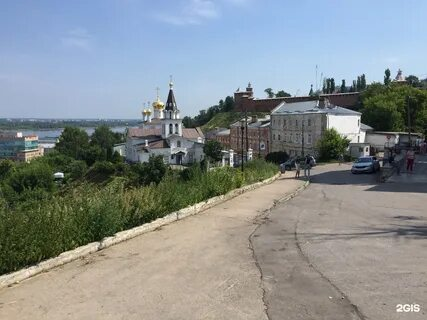

In [20]:
sample = data[data["en_txt"] == sorted_docs[2516][0]]
print(sample["Name"], "-", sample["en_txt"])
get_image(sample.iloc[0]["image"])

7077    Владимирский академический областной драматиче...
Name: Name, dtype: object - 7077    view of a building with statues on the side of it
Name: en_txt, dtype: object


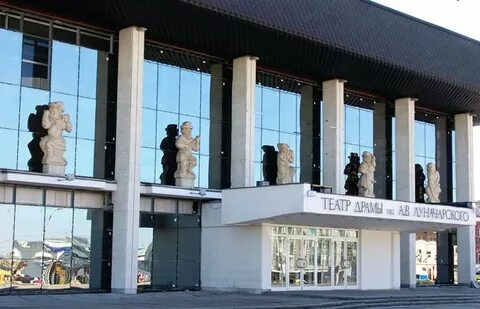

In [21]:
sample = data[data["en_txt"] == sorted_docs[-1][0]]
print(sample["Name"], "-", sample["en_txt"])
get_image(sample.iloc[0]["image"])

In [22]:
data["similarity"] = data["en_txt"].map(dict(sorted_docs))
data = data[data["similarity"] > 0.2]
data.shape

(6871, 10)

Сэмплируем 150 различных достопримечательностей для финальной базы RAG

In [23]:
unique_pairs = data[["Name", "City"]].drop_duplicates()
sampled_pairs = unique_pairs.sample(n=150, random_state=42)
samples_df = data.merge(sampled_pairs, on=["Name", "City"], how="inner")

Создаем описание для каждого объекта. В начале описания стоят фрагменты с наименьшей похожестью, в конце - с наибольшей. Тогда, если длина описания превысит размер контекстного окна, обрежутся самые похожие друг на друга части описания.

In [24]:
samples_df = samples_df.sort_values(by=["similarity"])
samples_df = (
    samples_df.groupby(["Name", "City"])["en_txt"].apply(" \n ".join).reset_index()
)
samples_df.head()

,Name,City,en_txt
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,there are two crosses in front of a church in ...
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,painting of a priest and a woman in a church \...
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,wooden structure with a steeple on a grassy ar...
3,Александро-Невский собор,Екатеринбург,white building with gold domes and a steeple \...
4,Белая башня,Екатеринбург,there is a car driving down the street in fron...


Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [25]:
embedding_model_name = "Alibaba-NLP/gte-multilingual-base"
print(
    f"Model's seq len: {SentenceTransformer(embedding_model_name, trust_remote_code=True).max_seq_length}"
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/123k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/611M [00:00<?, ?B/s]

Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: {'classifier.weight', 'classifier.bias'}
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's seq len: 8192


In [26]:
raw_knowledge_base = [
    LangchainDocument(
        page_content=doc["en_txt"],
        metadata={"City": doc["City"], "Landmark": doc["Name"]},
    )
    for doc in tqdm(datasets.Dataset.from_pandas(samples_df))
]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

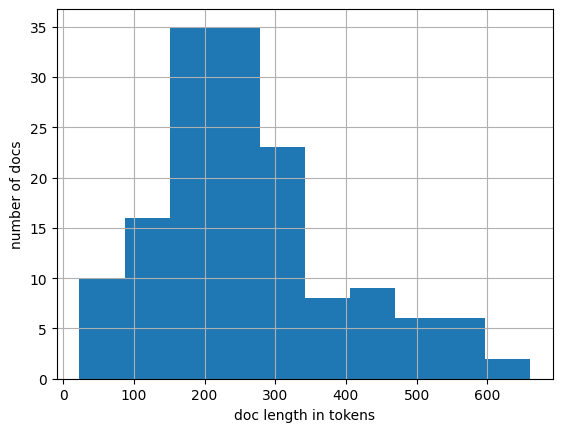

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(raw_knowledge_base)]
fig = pd.Series(lengths).hist()
plt.xlabel("doc length in tokens")
plt.ylabel("number of docs")
plt.show()

### Замечание: размер контекстного окна модели настолько велик, что в него помещаются описания любой длины (в рамках датасета), однако контекстное окно reader'а тоже 8192, поэтому chunk_size выставлен на одну восьмую от максимального размера

In [ ]:
def split_docs(
    knowledge_base: List[LangchainDocument],
    chunk_size: int = 1024,
    tokenizer_name: str = "Alibaba-NLP/gte-multilingual-base",
) -> List[LangchainDocument]:
    """Recursively splits documents into chunks that can fit into model context window.

    Args:
        knowledge_base (List[LangchainDocument]): List of documents
        chunk_size (int, optional): maximal lenght of a single document in tokens. Defaults to 1024.
        tokenizer_name (str, optional): name of the model's tokenizer. Defaults to "Alibaba-NLP/gte-multilingual-base".

    Returns:
        List[LangchainDocument]: Unique document chunks
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        separators=["\n", "\t", " ", ""],
    )
    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_docs(knowledge_base=raw_knowledge_base)

В качестве векторной базы выбрал chroma, тк она достаточно быстрая, хорошо работает с небольшимим документами и неплохо обрабатывает метаданные, которые могут быть важны в этом пайплайне. По умолчанию используется косинусное сходство

In [29]:
embedding_model = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    model_kwargs={"device": "cuda", "trust_remote_code": True},
    multi_process=True,
    encode_kwargs={"normalize_embeddings": True},
)
vector_db = Chroma.from_documents(docs_processed, embedding_model)

<ipython-input-29-aa73f0a8e3b3>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: {'classifier.weight', 'classifier.bias'}
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSeque

In [30]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
reader_model_name = "t-tech/T-lite-it-1.0"
model = AutoModelForCausalLM.from_pretrained(
    reader_model_name, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(reader_model_name)
tokenizer.model_max_length

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.87G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.90k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

8192

In [31]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)

In [32]:
reader_llm = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=512,
)

Device set to use cuda:0


In [33]:
reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [ ]:
def answer_with_rag(
    question: str,
    llm: pipeline,
    knowledge_index,
    reranker: RAGPretrainedModel,
    num_retrieved_docs: int = 15,
    num_docs_final: int = 5,
) -> Tuple[str, List[str]]:
    """RAG pipeline with reranking of retrieved chuks.

    Args:
        question (str): user querry
        llm (pipeline): reader model, that generates the answer
        knowledge_index (_type_): vector database of document chunks
        reranker (RAGPretrainedModel): model used for reranking the retrieved chunks
        num_retrieved_docs (int, optional): Number of documents that are picked during the retrieval process. Defaults to 15.
        num_docs_final (int, optional): Numver of documents that are passed to a reader after reranking. Defaults to 5.

    Returns:
        Tuple[str, List[str]]: answer to a user querry and a list of retrieved documents
    """
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]

    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    context = "\nExtracted documents:\n"
    context += "".join(
        [f"\nDocument {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [35]:
question = "Tell me about churches"

answer, relevant_docs = answer_with_rag(
    question, reader_llm, vector_db, reranker=reranker
)

=> Retrieving documents...
=> Reranking documents...


/usr/local/lib/python3.11/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


=> Generating answer...


In [36]:
answer

'The context provides descriptions of various churches, including their architectural features such as domes, steeples, crosses, and roofs. Churches are depicted in urban and rural settings, some with natural elements like rivers or fields, and others with historical or ornate details like clocks and altars. The churches vary in size, materials (wooden, stone), and colors (green, blue, white). They often have additional structures like benches, balconies, and spires. Some include religious artwork inside or outside, such as paintings, statues, and chandeliers. Overall, these descriptions suggest a diverse range of church designs and locations across different contexts. (Sources: Documents 0-4)'

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

In [37]:
query_vector = embedding_model.embed_query(question)

In [38]:
collection = vector_db._collection
stored_embeddings = collection.get(include=["embeddings", "metadatas", "documents"])
db_vectors = np.array(stored_embeddings["embeddings"])
vector_space = np.vstack([db_vectors, query_vector])
reducer = umap.UMAP(n_components=2, random_state=42)
reduced_space = reducer.fit_transform(vector_space)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [39]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": reduced_space[i, 0],
            "y": reduced_space[i, 1],
            "city": docs_processed[i].metadata["City"],
            "landmark": docs_processed[i].metadata["Landmark"],
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(reduced_space) - 1)
    ]
    + [
        {
            "x": reduced_space[-1, 0],
            "y": reduced_space[-1, 1],
            "city": "User query",
            "landmark": question,
            "size_col": 10,
            "symbol": "star",
        }
    ]
)

fig = px.scatter(
    df,
    x="x",
    y="y",
    color="city",
    hover_data="landmark",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Город</b>",
    title="<b>2D-проекция вложений чанка с помощью UMAP</b>",
)
fig.show()

In case that the plot is hidden for some reason:

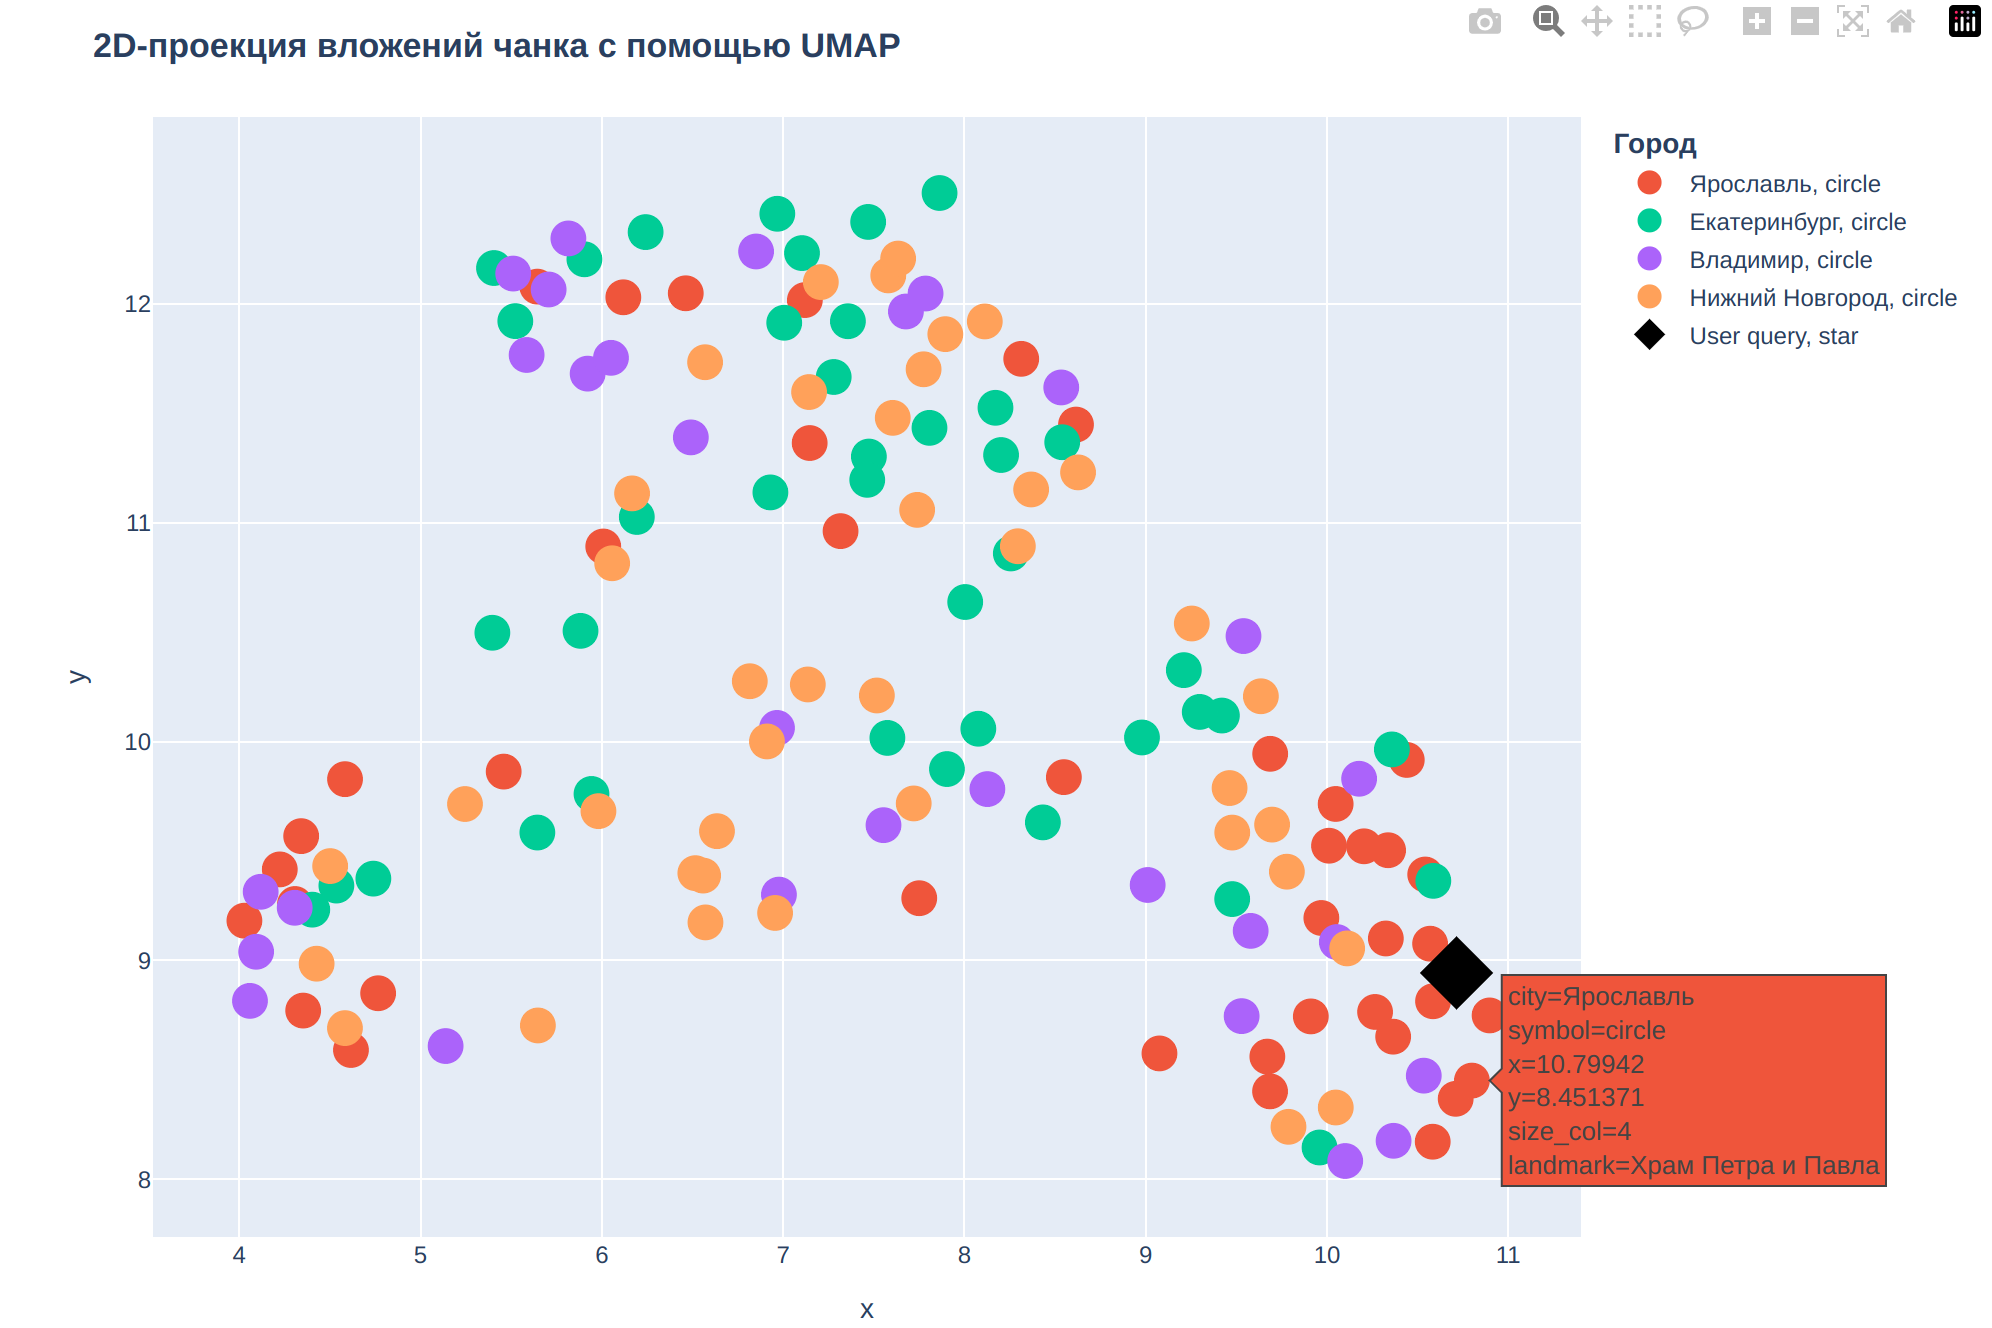

Векторы хорошо разделились: отчетливо видны группы архитекурных строений, музеев, природных памятников. Также внутри каждого кластера можно заметить, что объекты объединяются по городам

# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

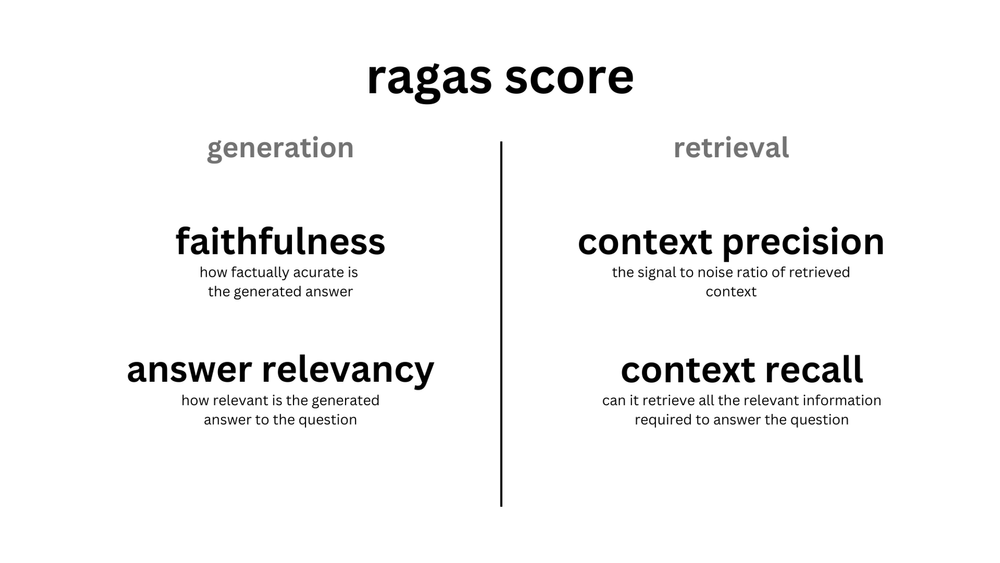

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [41]:
QA_model_name = "t-tech/T-lite-it-1.0"
QA_model = AutoModelForCausalLM.from_pretrained(
    QA_model_name, quantization_config=bnb_config
)
QA_tokenizer = AutoTokenizer.from_pretrained(QA_model_name)

QA_llm = pipeline(
    model=QA_model,
    tokenizer=QA_tokenizer,
    task="text-generation",
    return_full_text=False,
    max_new_tokens=100,
)
QA_tokenizer.model_max_length

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


8192

In [ ]:
QA_generation_prompt = """
Your task is to write a factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question MUST NOT mention something like "in the context" or "according to".

Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: {context}\n
Output:::"""


def generate_questions(n_generations: int, docs: List[LangchainDocument]) -> dict:
    """Generates questions to randomly sampled documents from the database and answers to these questions.

    Args:
        n_generations (int): number of questions to generate
        docs (List[LangchainDocument]): document database

    Returns:
        dict: contains generated question, answers to the questions, answers and a corresponding document
    """
    outputs = []
    for sampled_context in tqdm(random.sample(docs, n_generations)):
        output_QA_couple = QA_llm(
            QA_generation_prompt.format(context=sampled_context.page_content),
            max_new_tokens=100,
        )[0]["generated_text"]
        try:
            question = output_QA_couple.split("Factoid question: ")[-1].split(
                "Answer: "
            )[0]
            answer = output_QA_couple.split("Answer: ")[-1]
            assert len(answer) < 300, "Answer is too long"
            outputs.append(
                {
                    "question": question.strip(),
                    "ground_truths": answer.strip(),
                    "context": sampled_context.page_content.strip(),
                }
            )
        except:
            pass
    return outputs

In [43]:
outputs = []
for i in range(2):
    outputs.extend(generate_questions(150, docs_processed))

  0%|          | 0/150 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/150 [00:00<?, ?it/s]

In [44]:
ragas_df = pd.DataFrame(outputs)
print(ragas_df.shape)
ragas_df.head()

(298, 3)


,question,ground_truths,context
0,What color is the roof of the building with a ...,The roof of the building with a clock on the t...,image of a group of statues and a statue of a ...
1,What type of structure is typically associated...,A building.,people walking down a street in front of a bui...
2,What type of building is depicted in the image...,The image depicts a tall brick building with a...,cars parked in front of a building with a sign...
3,What color is the building with a red arrow on...,The building has a red arrow on its front.,there is a staircase leading to a second floor...
4,What type of building is depicted in the context?,There is a large building with a large blue an...,a picture of a picture of a space station with...


In [ ]:
num_answers = 10  # change according to resources
answers = []
for question in tqdm(ragas_df["question"][:num_answers]):
    answer, _ = answer_with_rag(question, reader_llm, vector_db, reranker=reranker)
    answers.append(answer)


In [50]:
test = ragas_df[:num_answers]
test["answers"] = answers
test.head()

<ipython-input-50-00044a4dbb48>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,question,ground_truths,context,answers
0,What color is the roof of the building with a ...,The roof of the building with a clock on the t...,image of a group of statues and a statue of a ...,The roof of the building with a clock on the t...
1,What type of structure is typically associated...,A building.,people walking down a street in front of a bui...,A statue of a man on a horse is typically asso...
2,What type of building is depicted in the image...,The image depicts a tall brick building with a...,cars parked in front of a building with a sign...,The images depict various types of buildings w...
3,What color is the building with a red arrow on...,The building has a red arrow on its front.,there is a staircase leading to a second floor...,The building with a red arrow on its front is ...
4,What type of building is depicted in the context?,There is a large building with a large blue an...,a picture of a picture of a space station with...,The context describes various types of buildin...


In [ ]:
def answer_relevancy(
    questions: List[str], answers: List[str], embedding_model: HuggingFaceEmbeddings
) -> int:
    """Computes answer relevancy metric which shows the similarity between the question and answer.

    Args:
        questions (List[str]): user querries
        answers (List[str]): answers obtained from the rag pipeline
        embedding_model (HuggingFaceEmbeddings): model used for embedding questions and answers

    Returns:
        int: answer relevancy (mean cosine similarity)
    """
    cosine_simils = []
    for question, answer in tqdm(zip(questions, answers), total=len(questions)):
        question_embedding = embedding_model.embed_query(question)
        answer_embedding = embedding_model.embed_query(answer)
        cosine_simils.append(
            cosine_similarity([question_embedding], [answer_embedding])
        )
    return sum(cosine_simils) / len(cosine_simils)

# Протестируйте ваш RAG (3 балла)

In [ ]:
questions = test["question"][:10]
answers = test["answers"][:10]
ans_rel = answer_relevancy(questions, answers, embedding_model)
print(f"Answer relevancy: {ans_rel}")

  0%|          | 0/10 [00:00<?, ?it/s]

Answer relevancy: [[0.8063611]]
